In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, f1_score, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
import pickle
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# from imblearn.under_sampling import RandomUnderSampler

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', None)

# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')
# pd.reset_option('display.width')
# pd.reset_option('display.max_colwidth')

# pd.reset_option('all')

anomaly_data = pd.read_csv("rawtable-anomaly.csv")

In [ ]:
anomaly_data

In [ ]:
anomaly_data.columns

In [ ]:
anomaly_data.info()

In [ ]:
anomaly_data.describe(include='all')

In [11]:
# desired_columns = ['Y', 'Data', 'XAU BGNL', 'BDIY', 'CRY', 'DXY', 'JPY', 'GBP','Cl1', 'VIX', 'USGG30YR', 'GT10', 'USGG2YR', 'USGG3M', 'US0001M', 'EONIA','LUMSTRUU']
desired_columns = ['Y', 'Data', 'XAU BGNL', 'BDIY', 'CRY', 'DXY', 'VIX', 'Cl1']

In [12]:
new_anomaly_data = anomaly_data[desired_columns]

In [14]:
total_duplicates = new_anomaly_data.duplicated().sum()
total_duplicates

np.int64(0)

In [ ]:
# Checks for missing values in the entire DataFrame
# total_missing = new_anomaly_data.isna().sum().sum()

# Checks for missing values in each column
total_missing = new_anomaly_data.isnull().sum()
total_missing

In [ ]:
new_anomaly_data.nunique()

In [ ]:
new_anomaly_data

In [17]:
print(new_anomaly_data['Y'].value_counts())

Y
0    874
1    237
Name: count, dtype: int64


In [ ]:
plt.figure(figsize=(8, 6))
new_anomaly_data['Y'].value_counts().plot(kind='bar')
plt.title('Distribution of Target Y anomaly data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [4]:
def plot_confusion_matrix(y_true, y_pred):
    from sklearn.metrics import confusion_matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_anomalies_over_time(data, y_true, y_pred):
    plt.figure(figsize=(20, 10))
    
    # Convert dates to datetime if they're not already
    dates = pd.to_datetime(data['Data'])
    
    # Create boolean masks with matching indices
    true_mask = pd.Series(y_true == 1, index=data.index)
    pred_mask = pd.Series(y_pred == 1, index=data.index)
    
    # Plot actual anomalies
    plt.subplot(2, 1, 1)
    plt.plot(dates, data['VIX'], 'b-', label='VIX', alpha=0.5)
    plt.scatter(dates[true_mask], data['VIX'][true_mask], 
                color='red', label='Actual Anomalies', marker='o')
    plt.title('Actual Anomalies')
    plt.legend()
    plt.grid(True)
    
    # Plot predicted anomalies
    plt.subplot(2, 1, 2)
    plt.plot(dates, data['VIX'], 'b-', label='VIX', alpha=0.5)
    plt.scatter(dates[pred_mask], data['VIX'][pred_mask], 
                color='orange', label='Predicted Anomalies', marker='x')
    plt.title('Predicted Anomalies')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_pred_proba):
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# def plot_feature_importance(model, feature_names):
#     importances = pd.DataFrame({
#         'feature': feature_names,
#         'importance': model.feature_importances_
#     }).sort_values('importance', ascending=True)
    
#     plt.figure(figsize=(10, 8))
#     plt.barh(range(len(importances)), importances['importance'])
#     plt.yticks(range(len(importances)), importances['feature'])
#     plt.xlabel('Importance')
#     plt.title('Feature Importance')
#     plt.tight_layout()
#     plt.show()

def plot_feature_importance(model, feature_names):
    # If using pipeline, get the classifier
    if hasattr(model, 'named_steps'):
        classifier = model.named_steps['classifier']
    else:
        classifier = model
        
    # Create DataFrame with feature importances
    importances = pd.DataFrame({
        'feature': feature_names,
        'importance': classifier.feature_importances_
    }).sort_values('importance', ascending=True)
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(importances)), importances['importance'])
    plt.yticks(range(len(importances)), importances['feature'])
    plt.xlabel('Importance')
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

def plot_enhanced_anomalies_over_time(data, y_true, y_pred, fold):
    plt.figure(figsize=(20, 12))
    dates = pd.to_datetime(data['Data'])
    
    # Create masks
    true_mask = pd.Series(y_true == 1, index=data.index)
    pred_mask = pd.Series(y_pred == 1, index=data.index)
    
    # True Positives, False Positives, False Negatives
    tp_mask = true_mask & pred_mask
    fp_mask = (~true_mask) & pred_mask
    fn_mask = true_mask & (~pred_mask)
    
    plt.plot(dates, data['VIX'], 'b-', label='VIX', alpha=0.5)
    plt.scatter(dates[tp_mask], data['VIX'][tp_mask], 
                color='green', label='True Positives', marker='o')
    plt.scatter(dates[fp_mask], data['VIX'][fp_mask], 
                color='red', label='False Positives', marker='x')
    plt.scatter(dates[fn_mask], data['VIX'][fn_mask], 
                color='orange', label='False Negatives', marker='s')
    
    plt.title(f'Anomaly Detection Results - Fold {fold}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [5]:
def save_model_pickle(model, filename=None, fold=None, X=None, y=None):
    if filename is None:
        filename = f'anomaly_model_randomforest_{fold}.pkl'
    
    # Calculate model performance metrics
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    
    # Create metadata dictionary
    model_info = {
        'model': model,
        'metadata': {
            'fold': fold,
            'features': X.columns.tolist(),
            'n_samples': len(X),
            'performance': {
                'accuracy': accuracy,
                'f1_score': f1
            },
            'model_params': model.get_params(),
            'class_distribution': pd.Series(y).value_counts().to_dict()
        }
    }
    # Save model with metadata
    with open(filename, 'wb') as file:
        pickle.dump(model_info, file)
    print(f"Model saved as: {filename}")
    print(f"Metrics - Accuracy: {accuracy:.3f}, F1: {f1:.3f}")

def load_model(filename):
    if filename.endswith('.pkl'):
        with open(filename, 'rb') as file:
            model_info = pickle.load(file)
            
        # Print metadata
        print("\nModel Metadata:")
        for key, value in model_info['metadata'].items():
            print(f"{key}: {value}")
            
        return model_info['model']
    else:
        raise ValueError("Unsupported file format")
    
def add_time_features(df):
    # Convert to datetime
    df = df.copy()
    df['Data'] = pd.to_datetime(df['Data'])
    
    # Extract time components
    df['Month'] = df['Data'].dt.month
    df['Quarter'] = df['Data'].dt.quarter
    df['Year'] = df['Data'].dt.year
    df['DayOfWeek'] = df['Data'].dt.dayofweek
    
    # Create cyclical features for Month and DayOfWeek
    df['Month_sin'] = np.sin(2 * np.pi * df['Month']/12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month']/12)
    df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)
    
    return df

data_with_features = add_time_features(new_anomaly_data)    
    
X = new_anomaly_data.drop(['Y', 'Data'], axis=1)
y = new_anomaly_data['Y']

tscv = TimeSeriesSplit(n_splits=5)

accuracy_scores = []
f1_scores = []
all_predictions = []
all_true_values = []


# model = RandomForestClassifier(
#     # Handle Overfitting
#     max_depth=5,
#     min_samples_split=10,
#     min_samples_leaf=8,
#     max_features='log2',
#     n_estimators=200,
    
#     # Better class imbalance handling
#     class_weight={
#         0: 1,
#         1: 3
#     },
    
#     random_state=42
# )

model = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=4,
        n_estimators=300,
        random_state=42
    ))
])



def predict_with_threshold(model, X, threshold=0.5):
    """Make predictions using a lower threshold for the minority class"""
    y_proba = model.predict_proba(X)
    return (y_proba[:, 1] >= threshold).astype(int)

In [ ]:
for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    print(f"\nFold {fold} class distribution:")
    print("Train:", pd.Series(y_train).value_counts())
    print("Test:", pd.Series(y_test).value_counts())
    
    # Train model
    # model.fit(X_train, y_train)
    model.fit(X_train, y_train)
    
    # Make predictions
    # y_pred = model.predict(X_test)
    y_pred = predict_with_threshold(model, X_test, threshold=0.2)
    
    # Calculate scores
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    # f1 = f1_score(y_test, y_pred, zero_division=0)
    
    # Store scores
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    all_predictions.extend(y_pred)
    all_true_values.extend(y_test)
    
    # model = RandomForestClassifier(random_state=42)
    # model.fit(X_train, y_train)
    
    # save_model_pickle(model, filename=f'anomaly_model_randomforest_{fold}.pkl')
    save_model_pickle(
        model=model,
        filename=f'anomaly_model_randomforest_{fold}.pkl',
        fold=fold,
        X=X_train,
        y=y_train
    )
    # save_model_pickle(
    #     model=model,
    #     filename=f'anomaly_model_randomforest_{fold}.pkl',
    #     fold=fold,
    #     X=X_train,
    #     y=y_train
    # )
    
    
    print(f"\nFold {fold+1} Results:")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"F1-Score: {f1:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print(f"\nFold {fold} Visualizations:")

    # Confusion Matrix
    plot_confusion_matrix(y_test, y_pred)
    
    # Time Series Plot
    # test_data = data_with_features.iloc[test_idx].copy()
    # plot_anomalies_over_time(test_data, y_test, y_pred)
    test_data = data_with_features.iloc[test_idx].copy()
    plot_enhanced_anomalies_over_time(test_data, y_test, y_pred, fold)
    
    # ROC Curve
    y_pred_proba = model.predict_proba(X_test)
    plot_roc_curve(y_test, y_pred_proba)
    
    # Feature Importance
    plot_feature_importance(model, X.columns)


print("\nOverall Results:")
print(f"Average Accuracy: {np.mean(accuracy_scores):.3f} (+/- {np.std(accuracy_scores):.3f})")
print(f"Average F1-Score: {np.mean(f1_scores):.3f} (+/- {np.std(f1_scores):.3f})")

plt.figure(figsize=(15, 5))
plt.plot(range(len(accuracy_scores)), accuracy_scores, 'b-', label='Accuracy')
plt.plot(range(len(f1_scores)), f1_scores, 'r-', label='F1-Score')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Model Performance Across Folds')
plt.legend()
plt.grid(True)
plt.show()


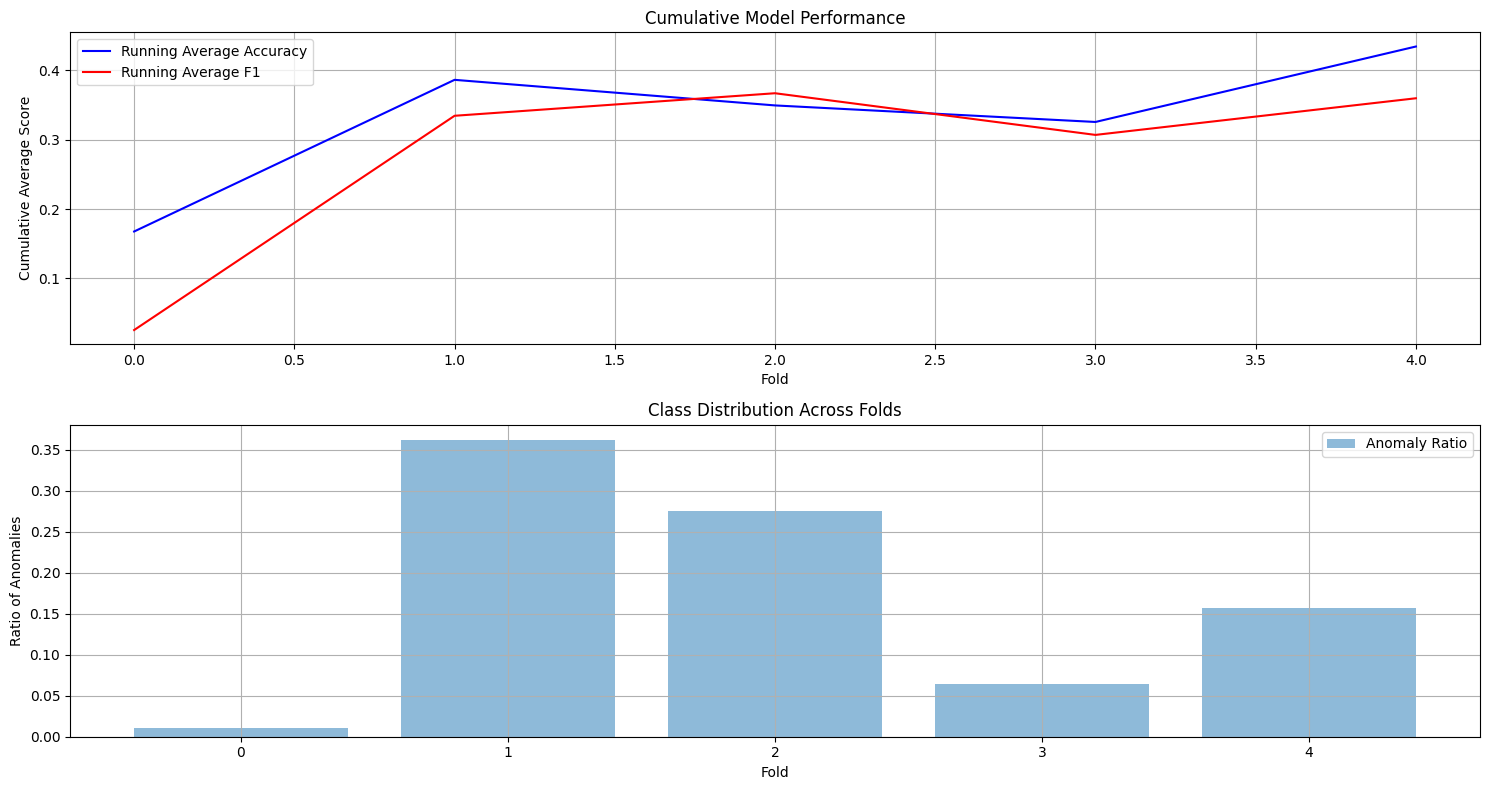

In [24]:
# 1. Cumulative Performance Plot
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(np.cumsum(accuracy_scores)/range(1, len(accuracy_scores)+1), 
         'b-', label='Running Average Accuracy')
plt.plot(np.cumsum(f1_scores)/range(1, len(f1_scores)+1), 
         'r-', label='Running Average F1')
plt.xlabel('Fold')
plt.ylabel('Cumulative Average Score')
plt.title('Cumulative Model Performance')
plt.legend()
plt.grid(True)

# 2. Class Distribution Plot
plt.subplot(2, 1, 2)
fold_numbers = range(len(accuracy_scores))
class_ratios = []
for fold, (_, test_idx) in enumerate(tscv.split(X)):
    y_test_fold = y.iloc[test_idx]
    ratio = (y_test_fold == 1).sum() / len(y_test_fold)
    class_ratios.append(ratio)

plt.bar(fold_numbers, class_ratios, alpha=0.5, label='Anomaly Ratio')
plt.xlabel('Fold')
plt.ylabel('Ratio of Anomalies')
plt.title('Class Distribution Across Folds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
# section: XGBoost functions


def calculate_rsi(series, window=14):
    """Calculate RSI technical indicator"""
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def create_time_features(df):
    """Create time-based and technical features"""
    df = df.copy()
    df['Data'] = pd.to_datetime(df['Data'])
    
    # Basic time features
    df['Month'] = df['Data'].dt.month
    df['DayOfWeek'] = df['Data'].dt.dayofweek
    df['Quarter'] = df['Data'].dt.quarter
    
    # RSI features for different windows
    for window in [5, 14, 21]:
        # Calculate RSI for VIX
        df[f'VIX_RSI_{window}'] = calculate_rsi(df['VIX'], window)
        
        # Calculate RSI for other relevant numeric columns
        for col in ['DXY', 'XAU BGNL', 'Cl1']:
            df[f'{col}_RSI_{window}'] = calculate_rsi(df[col], window)
    
    # Additional technical features
    for window in [5, 10, 20]:
        # Rolling statistics for VIX
        df[f'VIX_MA_{window}'] = df['VIX'].rolling(window=window).mean()
        df[f'VIX_STD_{window}'] = df['VIX'].rolling(window=window).std()
        
        # Price changes
        df[f'VIX_Change_{window}'] = df['VIX'].pct_change(window)
        df[f'DXY_Change_{window}'] = df['DXY'].pct_change(window)
    
    # Cross-asset ratios
    df['VIX_DXY_Ratio'] = df['VIX'] / df['DXY']
    df['Gold_Oil_Ratio'] = df['XAU BGNL'] / df['Cl1']
    
    # RSI crossovers and extremes
    df['VIX_RSI_Cross'] = (df['VIX_RSI_5'] > df['VIX_RSI_14']).astype(int)
    df['VIX_RSI_Overbought'] = (df['VIX_RSI_14'] > 70).astype(int)
    df['VIX_RSI_Oversold'] = (df['VIX_RSI_14'] < 30).astype(int)
    
    # Fill NaN values
    df = df.fillna(method='bfill').fillna(method='ffill')
    
    return df


# def create_advanced_features(df):
#     """Create advanced technical and cross-asset features"""
#     df = df.copy()
#     df['Data'] = pd.to_datetime(df['Data'])
    
#     # Time-based features
#     df['Month'] = df['Data'].dt.month
#     df['DayOfWeek'] = df['Data'].dt.dayofweek
#     df['Quarter'] = df['Data'].dt.quarter
    
#     # Volatility features
#     for window in [5, 10, 20]:
#         # VIX features
#         df[f'VIX_ROC_{window}'] = df['VIX'].pct_change(window)
#         df[f'VIX_STD_{window}'] = df['VIX'].rolling(window).std()
#         df[f'VIX_RSI_{window}'] = calculate_rsi(df['VIX'], window)
#         df[f'VIX_MA_{window}'] = df['VIX'].rolling(window).mean()
        
#         # DXY features
#         df[f'DXY_ROC_{window}'] = df['DXY'].pct_change(window)
#         df[f'DXY_RSI_{window}'] = calculate_rsi(df['DXY'], window)
        
#         # Gold features
#         df[f'GOLD_ROC_{window}'] = df['XAU BGNL'].pct_change(window)
#         df[f'GOLD_RSI_{window}'] = calculate_rsi(df['XAU BGNL'], window)
    
#     # Cross-asset ratios
#     df['VIX_DXY_Ratio'] = df['VIX'] / df['DXY']
#     df['Gold_Oil_Ratio'] = df['XAU BGNL'] / df['Cl1']
#     df['VIX_Gold_Ratio'] = df['VIX'] / df['XAU BGNL']
    
#     # Yield curve features
#     df['Yield_Spread_10_2'] = df['GT10'] - df['USGG2YR']
#     df['Yield_Spread_30_10'] = df['USGG30YR'] - df['GT10']
    
#     return df.fillna(method='bfill')

def find_optimal_threshold(y_true, y_pred_proba):
    """Find the optimal probability threshold for classification"""
    thresholds = np.arange(0.1, 0.9, 0.05)
    best_f1 = 0
    best_threshold = 0.5
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    return best_threshold

# Create time-based features
def create_time_features2(df):
    df = df.copy()
    df['Data'] = pd.to_datetime(df['Data'])
    
    # Basic time features
    df['Month'] = df['Data'].dt.month
    df['DayOfWeek'] = df['Data'].dt.dayofweek
    
    # Lag features
    df['VIX_Lag1'] = df['VIX'].shift(1)
    df['VIX_Lag5'] = df['VIX'].shift(5)
    
    # Rolling features
    df['VIX_MA5'] = df['VIX'].rolling(window=5).mean()
    df['VIX_STD5'] = df['VIX'].rolling(window=5).std()
    
    return df.fillna(method='bfill')

def plot_xgb_importance(model, X):
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df.head(15), x='importance', y='feature')
    plt.title('Top 15 Most Important Features')
    plt.tight_layout()
    plt.show()
    
def select_features(X_train, y_train, X_test):
    """Select most important features"""
    selector = SelectFromModel(
        xgb.XGBClassifier(random_state=42),
        threshold='median'  # Select top 50% of features
    )
    
    # Fit and transform
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    # Get selected feature names
    selected_features = X_train.columns[selector.get_support()].tolist()
    return X_train_selected, X_test_selected, selected_features
    
    
    


In [21]:
# section: XGBoost

# Prepare data with time features
# data_with_features = create_time_features(new_anomaly_data)
# data_with_features = create_time_features2(new_anomaly_data)
data_with_features = create_time_features(new_anomaly_data)
X = data_with_features.drop(['Y', 'Data'], axis=1)
y = data_with_features['Y']

# Initialize metrics storage
accuracy_scores = []
f1_scores = []
auc_scores = []
feature_importance_df = pd.DataFrame()


# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)
for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    print(f"\nFold {fold + 1}")
    
    # Split data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Feature selection
    # X_train_selected, X_test_selected, selected_features = select_features(X_train, y_train, X_test)
    # print(f"Selected {len(selected_features)} features")
    
    # Train a preliminary model to get feature importance
    prelim_model = xgb.XGBClassifier(random_state=42)
    prelim_model.fit(X_train, y_train)
    
    # Select important features
    importance_threshold = np.median(prelim_model.feature_importances_)
    important_features = X_train.columns[prelim_model.feature_importances_ > importance_threshold].tolist()
    
    # Filter features
    X_train_selected = X_train[important_features]
    X_test_selected = X_test[important_features]
    
    print(f"Selected {len(important_features)} features")
    
    # Calculate minority class ratio
    minority_ratio = len(y_train[y_train==1]) / len(y_train[y_train==0])
    target_ratio = min(0.5, minority_ratio * 2)  # Double the minority ratio, but cap at 0.5
    
    try:
        # Apply SMOTE: with adaptive sampling strategy
        smote = SMOTE(
            random_state=42,
            # sampling_strategy=target_ratio,
            sampling_strategy=0.5,
            k_neighbors=min(5, len(y_train[y_train==1])-1)  # Adjust neighbors based on minority class size
        )
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train_selected, y_train)
        print(f"Applied SMOTE - Original balance: {minority_ratio:.3f}, New balance: {target_ratio:.3f}")
    except ValueError:
        # If SMOTE fails, use original data
        print("SMOTE failed - using original imbalanced data")
        X_train_balanced, y_train_balanced = X_train_selected, y_train
    
    # Apply SMOTE only on training data
    # smote = SMOTE(random_state=42, sampling_strategy=0.3)  # Create minority class to be 30% of majority
    # X_train_balanced, y_train_balanced = smote.fit_resample(X_train_selected, y_train)
    
    # Calculate class weight
    # scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])
    # scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1]) * 2
    
    # model params:
    model = xgb.XGBClassifier(
        learning_rate=0.02,
        n_estimators=500,
        max_depth=4,
        min_child_weight=5,
        gamma=0.5,
        subsample=0.7,
        colsample_bytree=0.7,
        early_stopping_rounds=20,
        # Add class weights instead of SMOTE if it fails
        # scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1])*2,
        random_state=42
    )
    
    # Train model
    # model.fit(
    #     X_train, y_train,
    #     eval_set=[(X_test, y_test)],
    #     # eval_metric=['auc', 'logloss'],
    #     # early_stopping_rounds=10,
    #     verbose=False
    # )
    model.fit(
        X_train_balanced, 
        y_train_balanced,
        eval_set=[(X_test_selected, y_test)],
        # early_stopping_rounds=20,
        verbose=False
    )
    
    # Make predictions
    # y_pred = model.predict(X_test)
    # y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # y_pred_proba = model.predict_proba(X_test)[:, 1]
    # optimal_threshold = find_optimal_threshold(y_test, y_pred_proba)
    # y_pred = (y_pred_proba >= optimal_threshold).astype(int)
    
    y_pred_proba = model.predict_proba(X_test_selected)[:, 1]
    optimal_threshold = find_optimal_threshold(y_test, y_pred_proba)
    y_pred = (y_pred_proba >= optimal_threshold).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    auc_scores.append(auc)
    
     # Store feature importance
    fold_importance = pd.DataFrame({
        'feature': important_features,
        'importance': model.feature_importances_,
        'fold': fold + 1
    })
    feature_importance_df = pd.concat([feature_importance_df, fold_importance])
    
    print(f"Optimal Threshold: {optimal_threshold:.3f}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"F1-Score: {f1:.3f}")
    print(f"AUC-ROC: {auc:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot feature importance
    # plot_xgb_importance(model, X)
    # Print selected features for first fold
    if fold == 0:
        print("\nSelected Features:")
        for feature in important_features:
            print(f"- {feature}")

# Print overall results
print("\nOverall Results:")
print(f"Average Accuracy: {np.mean(accuracy_scores):.3f} (±{np.std(accuracy_scores):.3f})")
print(f"Average F1-Score: {np.mean(f1_scores):.3f} (±{np.std(f1_scores):.3f})")
print(f"Average AUC-ROC: {np.mean(auc_scores):.3f} (±{np.std(auc_scores):.3f})")

/var/folders/pg/wwfxmq4x1vx_t00m5pz1z4nr0000gp/T/ipykernel_16792/1269825319.py:51: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(method='ffill')
/Users/paulc1/miniforge3/envs/anomolly-detection/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/paulc1/miniforge3/envs/anomolly-detection/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.Classifier


Fold 1
Selected 17 features
SMOTE failed - using original imbalanced data
Optimal Threshold: 0.700
Accuracy: 0.962
F1-Score: 0.364
AUC-ROC: 0.988

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       183
           1       0.22      1.00      0.36         2

    accuracy                           0.96       185
   macro avg       0.61      0.98      0.67       185
weighted avg       0.99      0.96      0.97       185


Selected Features:
- XAU BGNL
- BDIY
- CRY
- DXY
- Month
- VIX_RSI_5
- DXY_RSI_5
- VIX_RSI_14
- DXY_RSI_14
- VIX_RSI_21
- DXY_RSI_21
- VIX_MA_5
- VIX_STD_5
- VIX_Change_10
- VIX_MA_20
- VIX_Change_20
- VIX_DXY_Ratio

Fold 2
Selected 17 features
Applied SMOTE - Original balance: 0.266, New balance: 0.500


/Users/paulc1/miniforge3/envs/anomolly-detection/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/paulc1/miniforge3/envs/anomolly-detection/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Optimal Threshold: 0.250
Accuracy: 0.557
F1-Score: 0.544
AUC-ROC: 0.735

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.46      0.57       118
           1       0.43      0.73      0.54        67

    accuracy                           0.56       185
   macro avg       0.59      0.59      0.56       185
weighted avg       0.64      0.56      0.56       185


Fold 3
Selected 17 features
Applied SMOTE - Original balance: 0.353, New balance: 0.500


/Users/paulc1/miniforge3/envs/anomolly-detection/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/paulc1/miniforge3/envs/anomolly-detection/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Optimal Threshold: 0.150
Accuracy: 0.757
F1-Score: 0.634
AUC-ROC: 0.819

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.75      0.82       134
           1       0.54      0.76      0.63        51

    accuracy                           0.76       185
   macro avg       0.72      0.76      0.73       185
weighted avg       0.80      0.76      0.77       185


Fold 4
Selected 17 features
Applied SMOTE - Original balance: 0.360, New balance: 0.500


/Users/paulc1/miniforge3/envs/anomolly-detection/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/paulc1/miniforge3/envs/anomolly-detection/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Optimal Threshold: 0.400
Accuracy: 0.930
F1-Score: 0.480
AUC-ROC: 0.805

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       173
           1       0.46      0.50      0.48        12

    accuracy                           0.93       185
   macro avg       0.71      0.73      0.72       185
weighted avg       0.93      0.93      0.93       185


Fold 5
Selected 17 features
Applied SMOTE - Original balance: 0.290, New balance: 0.500


/Users/paulc1/miniforge3/envs/anomolly-detection/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/paulc1/miniforge3/envs/anomolly-detection/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Optimal Threshold: 0.750
Accuracy: 0.924
F1-Score: 0.682
AUC-ROC: 0.878

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       156
           1       1.00      0.52      0.68        29

    accuracy                           0.92       185
   macro avg       0.96      0.76      0.82       185
weighted avg       0.93      0.92      0.91       185


Overall Results:
Average Accuracy: 0.826 (±0.152)
Average F1-Score: 0.541 (±0.113)
Average AUC-ROC: 0.845 (±0.085)


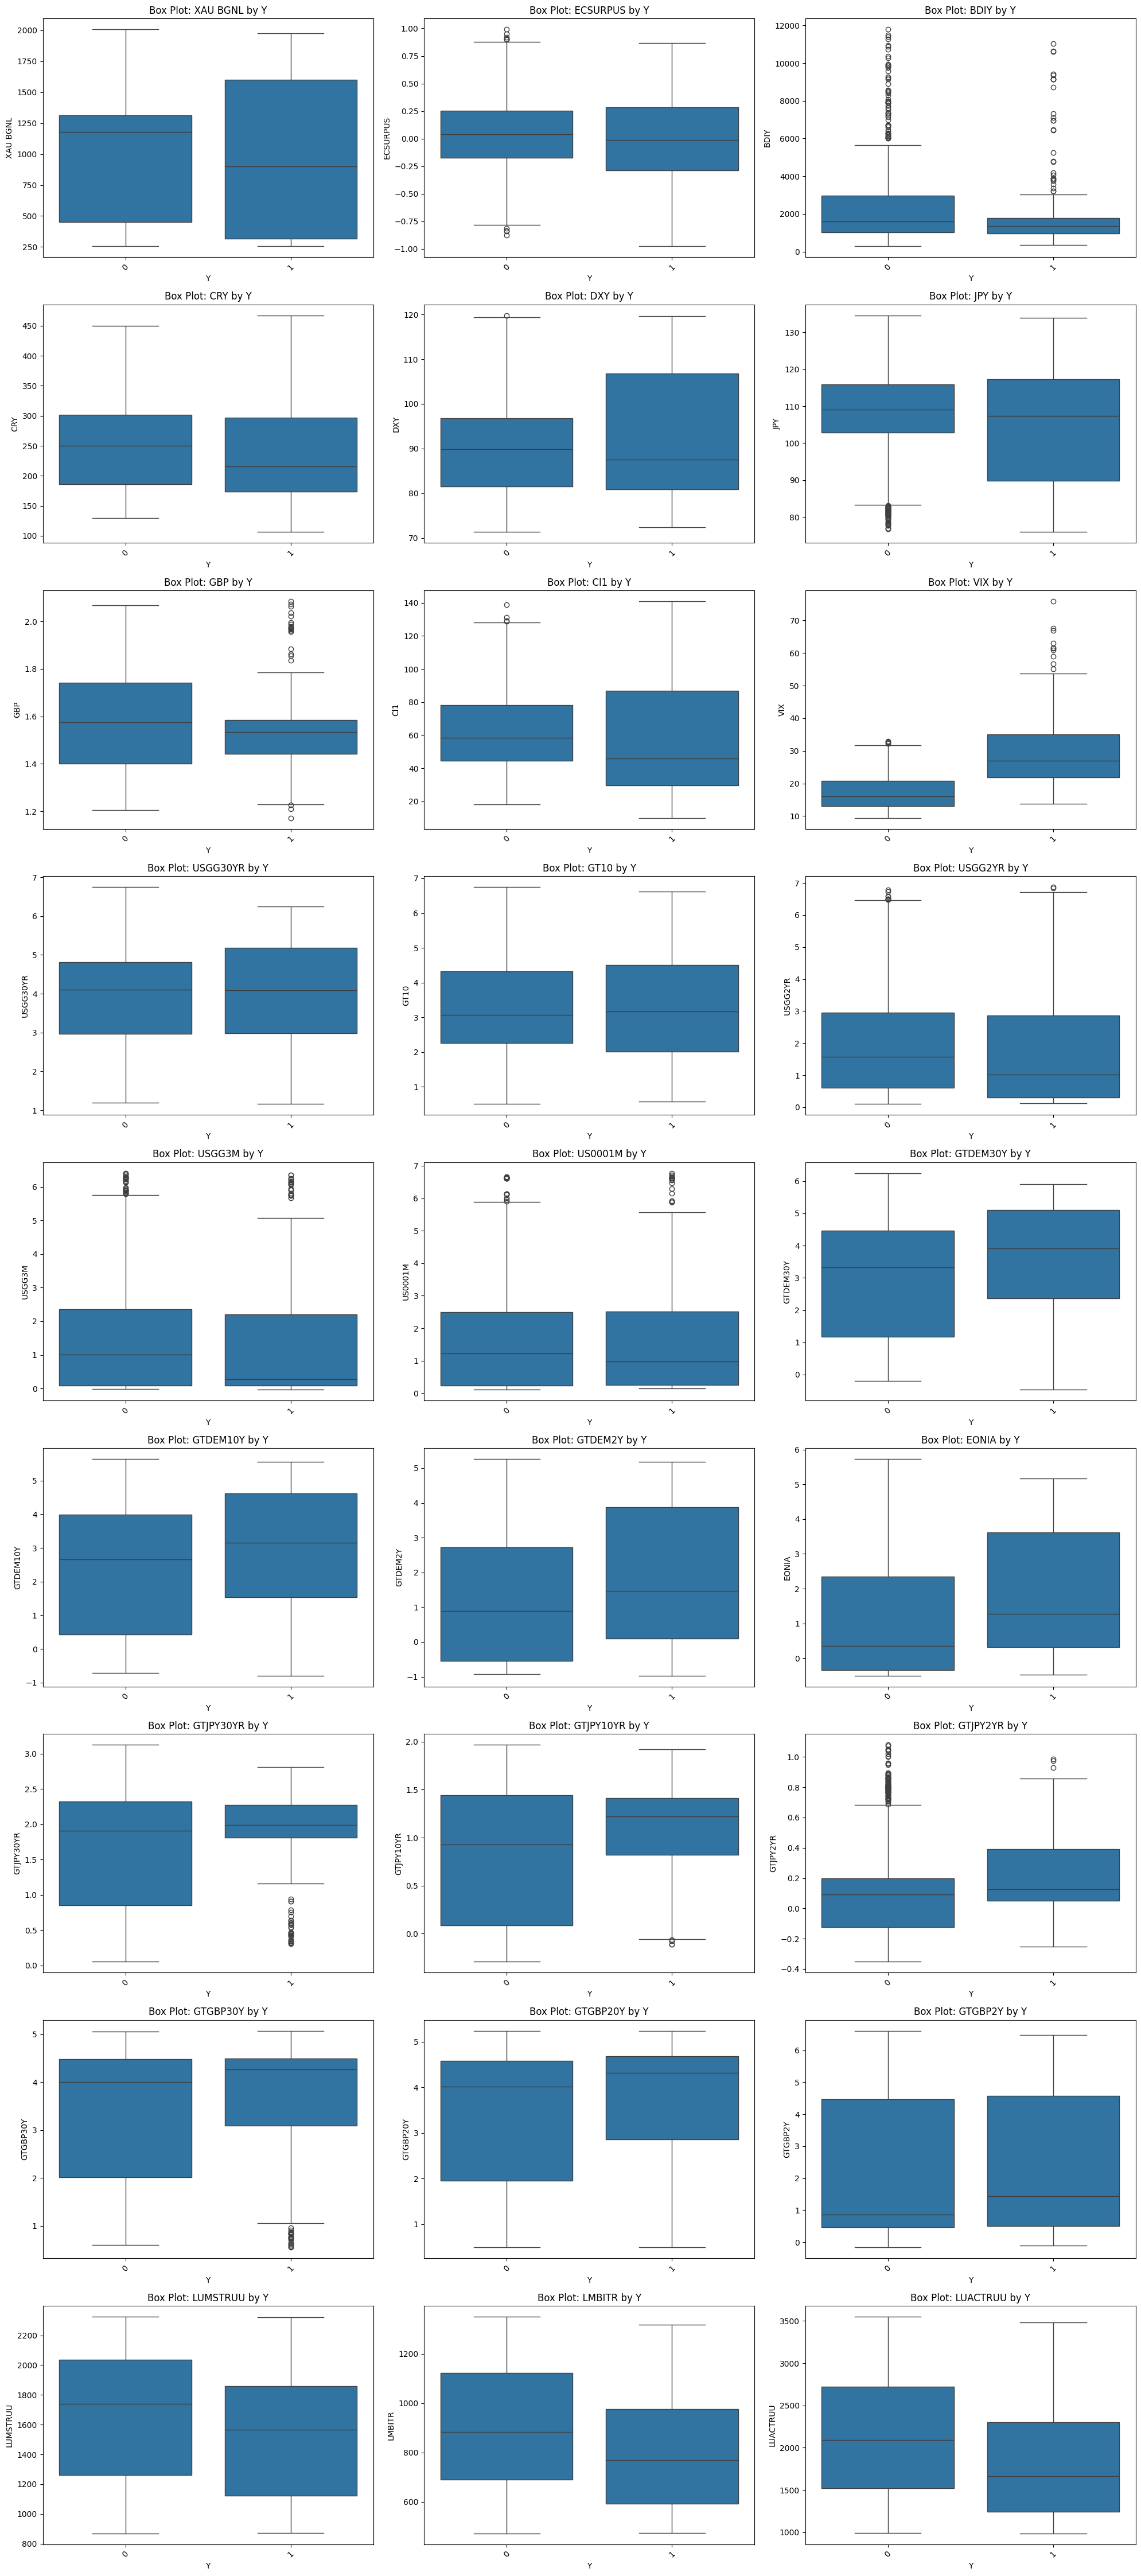

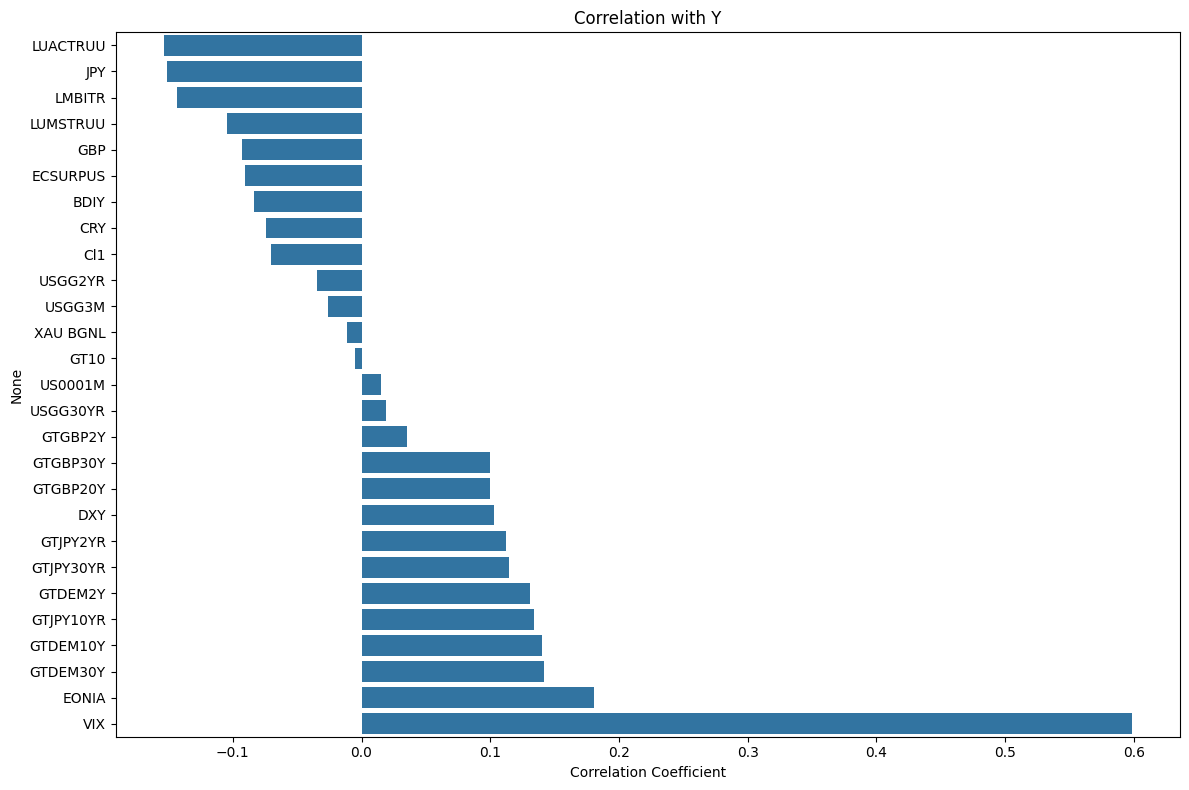


Statistical Analysis Results:

Top 10 Most Significant Features:
          p_value  effect_size  mean_diff
VIX        0.0000       1.4444    12.6190
EONIA      0.0000       0.4319     0.7576
LUACTRUU   0.0000      -0.3784  -258.7803
GTDEM30Y   0.0000       0.3488     0.6146
GTDEM2Y    0.0000       0.3170     0.5979
GTDEM10Y   0.0000       0.3462     0.6322
LMBITR     0.0000      -0.3554   -84.6242
GTJPY2YR   0.0000       0.2826     0.0815
LUMSTRUU   0.0000      -0.2551  -106.7894
BDIY       0.0002      -0.2046  -410.8119


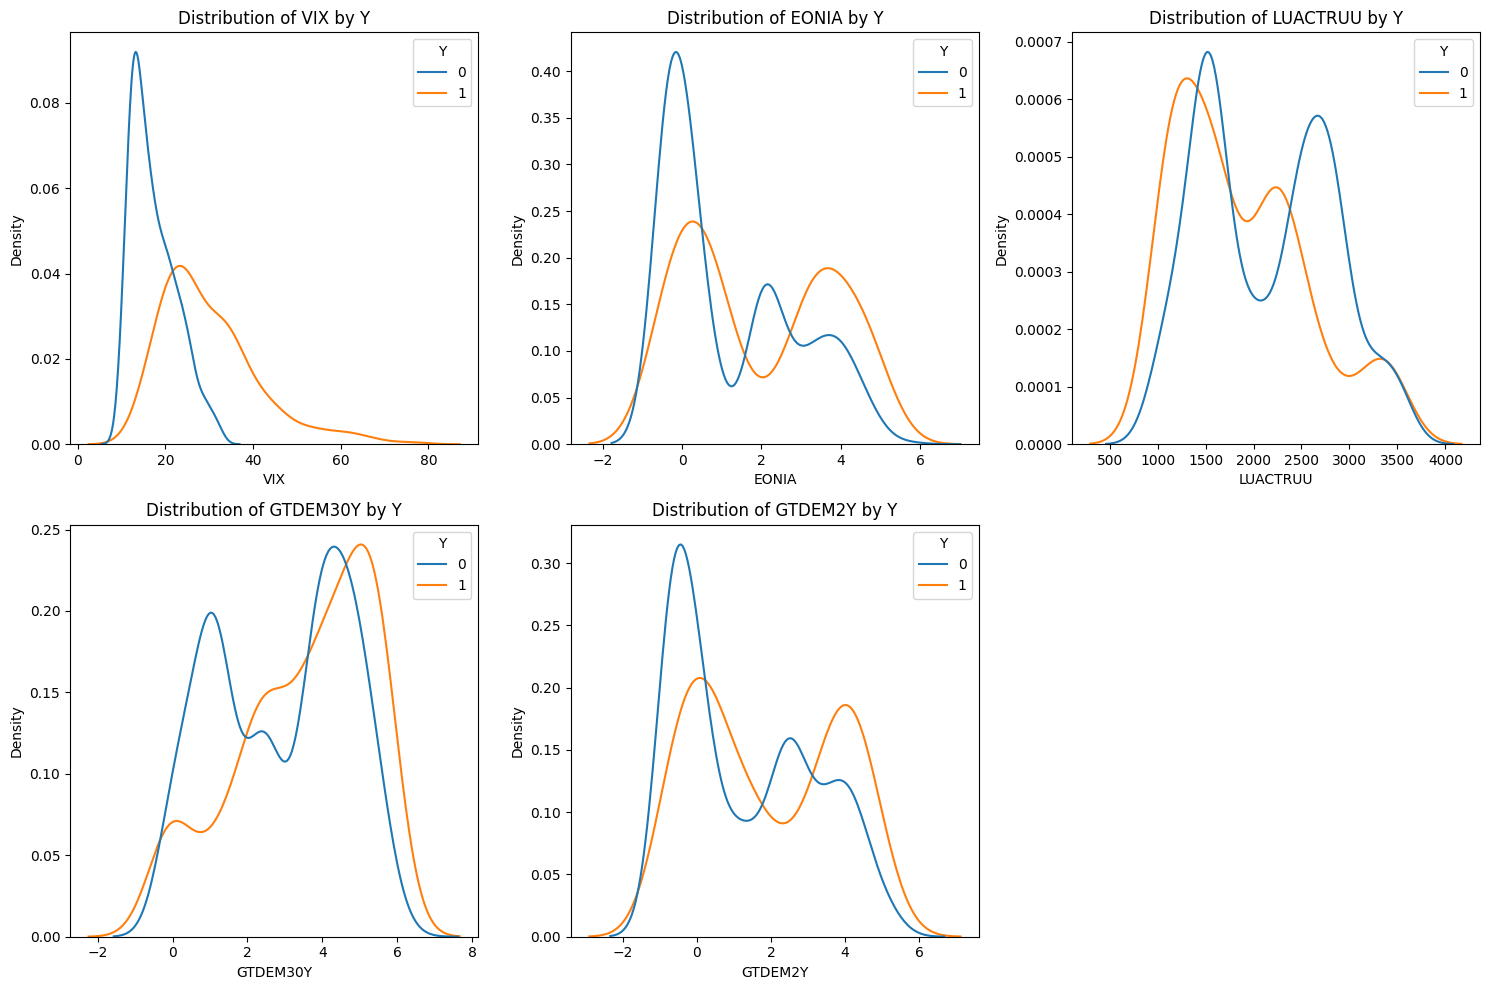


Top Features Summary:
           Feature  P-Value  Effect Size  Mean Difference
VIX            VIX      0.0       1.4444          12.6190
EONIA        EONIA      0.0       0.4319           0.7576
LUACTRUU  LUACTRUU      0.0      -0.3784        -258.7803
GTDEM30Y  GTDEM30Y      0.0       0.3488           0.6146
GTDEM2Y    GTDEM2Y      0.0       0.3170           0.5979


In [107]:
# section: LSTM

def bivariate_analysis(df, target_col='Y'):
    """
    Perform bivariate analysis between target variable and all other numeric columns
    """
    # Get numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols.remove(target_col)  # Remove target from features
    
    # Initialize statistical results dictionary
    stats_results = {}
    
    # Create subplots for each feature
    n_cols = 3
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    axes = axes.flatten()
    
    for idx, col in enumerate(numeric_cols):
        # 1. Box Plot
        plt.subplot(n_rows, n_cols, idx+1)
        sns.boxplot(x=df[target_col], y=df[col])
        plt.title(f'Box Plot: {col} by {target_col}')
        plt.xticks(rotation=45)
        
        # 2. Statistical Tests
        # Mann-Whitney U test for non-normal distributions
        stat, p_value = stats.mannwhitneyu(
            df[df[target_col]==0][col].dropna(),
            df[df[target_col]==1][col].dropna(),
            alternative='two-sided'
        )
        
        # Calculate Effect Size (Cohen's d)
        d = (df[df[target_col]==1][col].mean() - df[df[target_col]==0][col].mean()) / \
            np.sqrt((df[df[target_col]==1][col].std()**2 + df[df[target_col]==0][col].std()**2) / 2)
        
        stats_results[col] = {
            'p_value': p_value,
            'effect_size': d,
            'mean_diff': df[df[target_col]==1][col].mean() - df[df[target_col]==0][col].mean()
        }
    
    plt.tight_layout()
    plt.show()
    
    # 3. Correlation Plot
    plt.figure(figsize=(12, 8))
    correlations = df[numeric_cols + [target_col]].corr()[target_col].sort_values()
    sns.barplot(x=correlations.values[:-1], y=correlations.index[:-1])
    plt.title(f'Correlation with {target_col}')
    plt.xlabel('Correlation Coefficient')
    plt.tight_layout()
    plt.show()
    
    # 4. Print Statistical Results
    results_df = pd.DataFrame(stats_results).T
    results_df = results_df.sort_values('p_value')
    print("\nStatistical Analysis Results:")
    print("\nTop 10 Most Significant Features:")
    print(results_df.head(10).round(4))
    
    return results_df

# Assuming your dataframe is called 'new_anomolly_data'
# Run the analysis
results = bivariate_analysis(new_anomaly_data, target_col='Y')

# Additional Analysis: Distribution Plots for Top Features
top_features = results.head(5).index.tolist()
plt.figure(figsize=(15, 10))

for idx, feature in enumerate(top_features, 1):
    plt.subplot(2, 3, idx)
    sns.kdeplot(data=new_anomaly_data, x=feature, hue='Y', common_norm=False)
    plt.title(f'Distribution of {feature} by Y')

plt.tight_layout()
plt.show()

# Create summary table of the most important relationships
summary_table = pd.DataFrame({
    'Feature': top_features,
    'P-Value': results.loc[top_features, 'p_value'],
    'Effect Size': results.loc[top_features, 'effect_size'],
    'Mean Difference': results.loc[top_features, 'mean_diff']
}).round(4)

print("\nTop Features Summary:")
print(summary_table)

# Optional: Chi-square test for categorical variables
def analyze_categorical_relationships(df, target_col='Y'):
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    if categorical_cols:
        print("\nChi-square tests for categorical variables:")
        for col in categorical_cols:
            chi2, p_val, dof, expected = stats.chi2_contingency(
                pd.crosstab(df[col], df[target_col])
            )
            print(f"\n{col}:")
            print(f"Chi-square statistic: {chi2:.4f}")
            print(f"p-value: {p_val:.4f}")

# Call the function
analyze_categorical_relationships(data_with_features, target_col='Y')
